# ¿Existirán grupos de personas que compartan la misma tasa de reincidencia? Si existen, ¿Qué atributos componen a dichos grupos?

Como se vio en la pregunta 2, las tablas que poseen una gran incidencia en el decile score es principalmente people, por lo que mediante un script de r se decide juntar esta con datos relevantes de charge

Porque incluir charge a pesar de su baja correlacion con decile score?

- Consideramos que contiene información util que puede revelar alguna agrupacion natural, ademas de informacion con respecto a la reincidencia
- Jailhistory se descarta por tener datos similares a los de people

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors


In [2]:
# Load data
main_people = pd.read_csv('../data/cleaned/people_joined_charge_decile.csv', index_col=0).drop('c_days_from_compas', axis=1)
main_people.head()

,id,sex,race,dob,juv_fel_count,juv_misd_count,juv_other_count,compas_screening_date,priors_count,days_b_screening_arrest,...,min_degree,avg_degree,med_degree,charges_recid,charges_no_recid,charges_total,charge_latest,decile_recid,decile_violence,decile_fail_to_appear
1,1,Male,Other,0.27451,0,0,0,0.93632,0,-0.00003,...,0.00,0.18125,0.000,2,6,8,0.93900,1,1,1
2,3,Male,African-American,0.62141,0,0,0,0.93088,0,-0.00003,...,0.85,0.86250,0.850,3,1,4,0.93523,3,1,6
3,4,Male,African-American,0.71427,0,0,1,0.93299,4,-0.00003,...,0.00,0.45833,0.600,17,19,36,0.96159,4,3,7
4,5,Male,African-American,0.73115,0,1,0,0.93050,1,0.00000,...,0.00,0.37143,0.550,2,5,7,0.94266,8,6,3
5,6,Male,Other,0.53161,0,0,0,0.93247,2,0.00000,...,0.00,0.57500,0.725,0,4,4,0.92342,1,1,1


In [3]:
# Ahora pasamos los elementos categoricos a numericos
main_people.replace(['Male', 'Female'], [1, 0], inplace=True)
people_race = pd.get_dummies(main_people['race'], prefix='race', prefix_sep="_")
main_people = pd.concat([main_people, people_race], axis=1).drop('race', axis=1)
main_people.head()

,id,sex,dob,juv_fel_count,juv_misd_count,juv_other_count,compas_screening_date,priors_count,days_b_screening_arrest,c_jail_in,...,charge_latest,decile_recid,decile_violence,decile_fail_to_appear,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other
1,1,1,0.27451,0,0,0,0.93632,0,-0.00003,0.93629,...,0.93900,1,1,1,0,0,0,0,0,1
2,3,1,0.62141,0,0,0,0.93088,0,-0.00003,0.93085,...,0.93523,3,1,6,1,0,0,0,0,0
3,4,1,0.71427,0,0,1,0.93299,4,-0.00003,0.93296,...,0.96159,4,3,7,1,0,0,0,0,0
4,5,1,0.73115,0,1,0,0.93050,1,0.00000,0.93050,...,0.94266,8,6,3,1,0,0,0,0,0
5,6,1,0.53161,0,0,0,0.93247,2,0.00000,0.93247,...,0.92342,1,1,1,0,0,0,0,0,1


In [4]:
# Como se ve, las columnas que corresponden a reincidencia son is_recid, num_r_cases, charges_recid, charges_not_recid, decile_recid
# Entonces las quitamos para hacer el clustering
blind_recid_people = main_people.drop(['is_recid', 'num_r_cases', 'charges_recid', 'charges_total', 'charge_latest', 'decile_recid'], axis=1)
blind_recid_people.head()

,id,sex,dob,juv_fel_count,juv_misd_count,juv_other_count,compas_screening_date,priors_count,days_b_screening_arrest,c_jail_in,...,med_degree,charges_no_recid,decile_violence,decile_fail_to_appear,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other
1,1,1,0.27451,0,0,0,0.93632,0,-0.00003,0.93629,...,0.000,6,1,1,0,0,0,0,0,1
2,3,1,0.62141,0,0,0,0.93088,0,-0.00003,0.93085,...,0.850,1,1,6,1,0,0,0,0,0
3,4,1,0.71427,0,0,1,0.93299,4,-0.00003,0.93296,...,0.600,19,3,7,1,0,0,0,0,0
4,5,1,0.73115,0,1,0,0.93050,1,0.00000,0.93050,...,0.550,5,6,3,1,0,0,0,0,0
5,6,1,0.53161,0,0,0,0.93247,2,0.00000,0.93247,...,0.725,4,1,1,0,0,0,0,0,1


<AxesSubplot:>

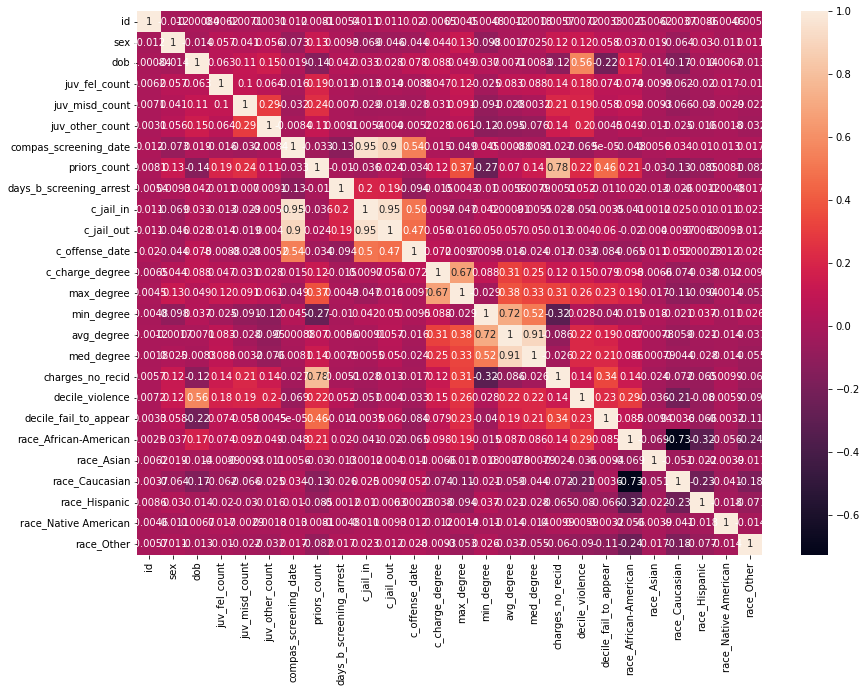

In [5]:
# Ahora revisamos si existen elementos muy correlacionados
plt.figure(figsize=(14, 10))
sns.heatmap(blind_recid_people.corr(), annot=True)

<AxesSubplot:>

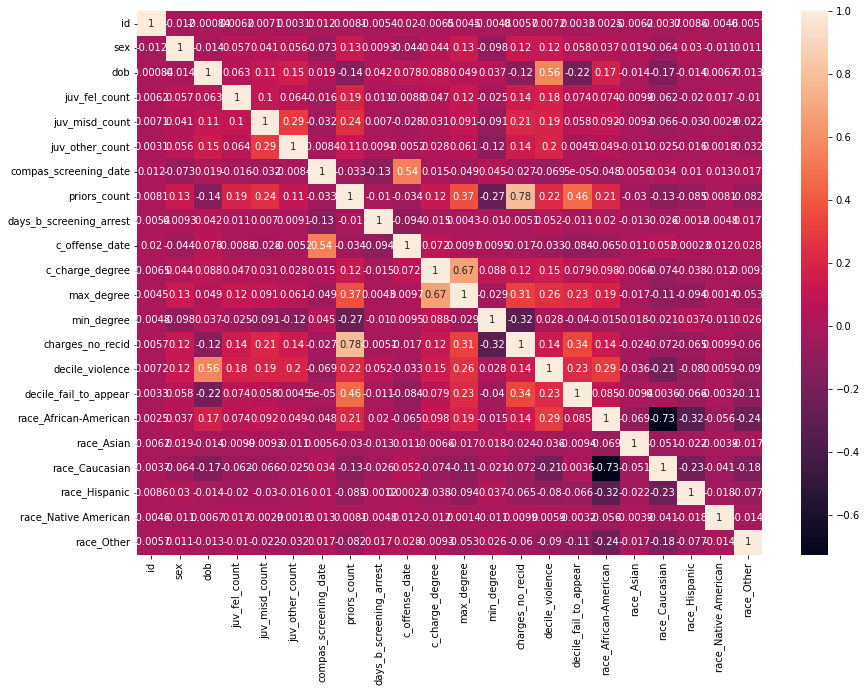

In [6]:
# Como se ve, la correlacion entre c_jail_in y c_jail_out es muy alta, por lo que podemos dejar compas_screening_date como representante de ambos.
# Lo mismo pasa con min, med y avg degree, con lo cual podemos quedarnos con min
# priors_count y degrees_total tambien, pero a pesar de tener una relación alta, son cosas distintas.
blind_recid_people.drop(['c_jail_in', 'c_jail_out', 'med_degree', 'avg_degree'], axis=1, inplace=True)
plt.figure(figsize=(14, 10))
sns.heatmap(blind_recid_people.corr(), annot=True)

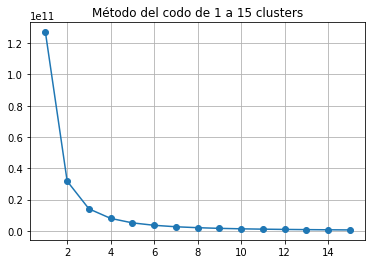

In [7]:
# Ahora podemos hacer clustering, empezando con KMeans
# Usaremos la técnica del codo
km_sse = []
km_clusters = [i for i in range(1, 16)]
for k in km_clusters:
    kmeans = KMeans(n_clusters=k).fit(blind_recid_people)
    km_sse.append(kmeans.inertia_)

plt.plot(km_clusters, km_sse, marker='o')
plt.title('Método del codo de 1 a 15 clusters')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Clusters de la tabla blind_recid_people usando KMeans')

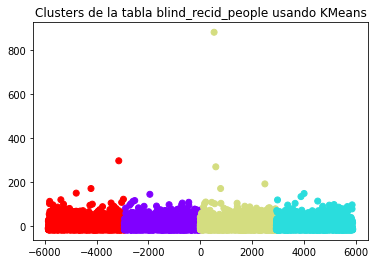

In [8]:
# Usaremos 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0).fit(blind_recid_people)
km_cl = kmeans.labels_
# Reducimos la dimensionalidad usando PCA para ver los resultados visuales
X = PCA(n_components=2, random_state=0).fit_transform(main_people)
plt.scatter(X[:, 0], X[:, 1], c=km_cl, cmap='rainbow')
plt.title('Clusters de la tabla blind_recid_people usando KMeans');

In [9]:
# Revisamos el porcentaje de reincidencia por cluster
main_people['km_cl'] = km_cl
main_people.groupby('km_cl').is_recid.mean()

km_cl
0    0.336968
1    0.336476
2    0.342471
3    0.321416
Name: is_recid, dtype: float64

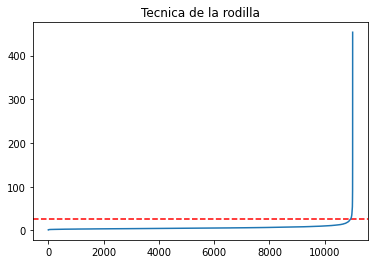

In [10]:
# Demasiado iguales con respecto a la reincidencia, por lo que cambiamos a DBSCAN
# Usaremos la tecnica de la rodilla para 3 distintos k=[4,5,6]
nbrs = NearestNeighbors(n_neighbors=10).fit(blind_recid_people)
distances, indices = nbrs.kneighbors(blind_recid_people)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.title('Tecnica de la rodilla')
plt.axhline(y=25, color='r', linestyle='--') #Ajuste el valor para y
plt.plot(distances)
plt.show()


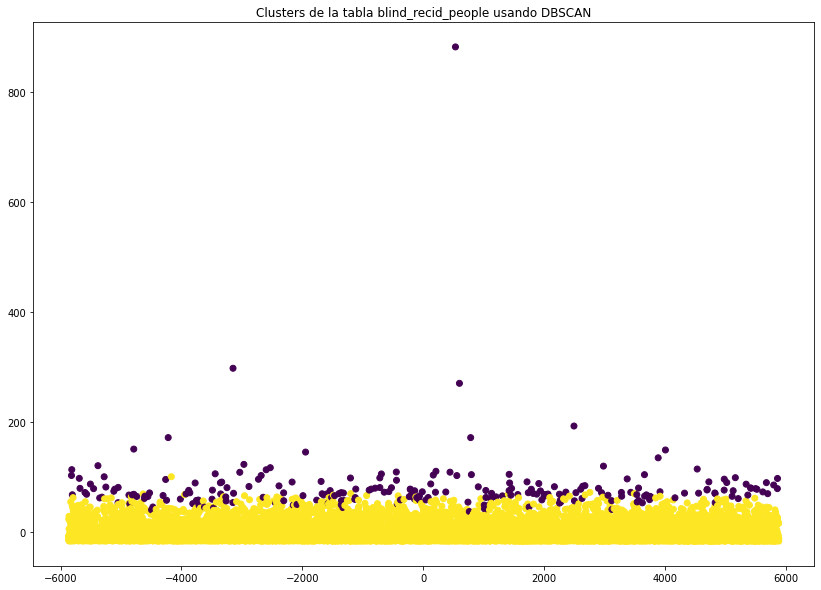

In [11]:
# Nos quedamos con 25 y 4
dbscan = DBSCAN(eps=25, min_samples=10).fit(blind_recid_people)
db_cl = dbscan.labels_
plt.figure(figsize=(14, 10))
plt.title('Clusters de la tabla blind_recid_people usando DBSCAN')
plt.scatter(X[:, 0], X[:, 1], c=db_cl);

In [12]:
# Revisamos la reincidencia por cluster, filtramos los outlayers
main_people['db_cl'] = db_cl
main_people.groupby('db_cl').is_recid.mean()

db_cl
-1    0.617391
 0    0.328264
Name: is_recid, dtype: float64

In [13]:
# DBScan no nos da una solucion buena para la reincidencia, pues solo consigue identificar outlayers, por lo mismo, puede que sirva como metodo de subsampling para la clasificacion
main_people.db_cl.value_counts()

 0    10784
-1      230
Name: db_cl, dtype: int64

In [14]:
# Ahora vamos a usar agglomerative clustering
complete = linkage(blind_recid_people, 'complete')
single = linkage(blind_recid_people, 'single')
average = linkage(blind_recid_people, 'average')
ward = linkage(blind_recid_people, 'ward')

dendrogram(complete, labels=blind_recid_people.index, orientation='top', leaf_rotation=90)
plt.title('Complete')
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001EABCB09DC0> (for post_execute):


KeyboardInterrupt: 

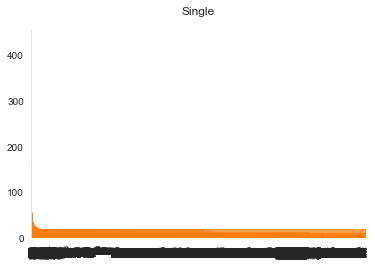

In [ ]:
dendrogram(single, labels=blind_recid_people.index, orientation='top', leaf_rotation=90)
plt.title('Single')
plt.show()

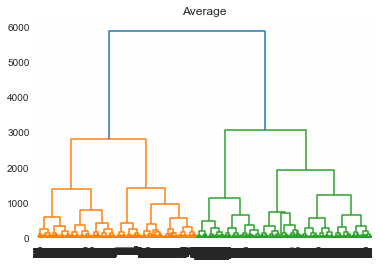

In [ ]:
dendrogram(average, labels=blind_recid_people.index, orientation='top', leaf_rotation=90)
plt.title('Average')
plt.show()

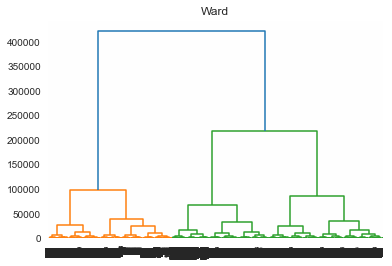

In [ ]:
dendrogram(ward, labels=blind_recid_people.index, orientation='top', leaf_rotation=90)
plt.title('Ward')
plt.show()

In [ ]:
# Descartamos el metodo single puesto que no se puede definir la altura de corte de manera visual
# Para complete el trehshold sera de 6000, para average de 3000 y para ward de 1000000
complete_agg = AgglomerativeClustering(n_clusters=None, linkage='complete', distance_threshold=5000).fit(blind_recid_people)
average_agg = AgglomerativeClustering(n_clusters=None, linkage='average', distance_threshold=2500).fit(blind_recid_people)
ward_agg = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=150000).fit(blind_recid_people)

# Ahora revisamos el porcentaje de reincidencia por cluster
main_people['complete_cl'] = complete_agg.labels_
main_people.groupby('complete_cl').is_recid.mean()

complete_cl
0    0.331645
1    0.342886
2    0.337160
3    0.322751
Name: is_recid, dtype: float64

In [ ]:
main_people['average_cl'] = average_agg.labels_
main_people.groupby('average_cl').is_recid.mean()

average_cl
0    0.339503
1    0.318267
2    0.340265
3    0.338544
Name: is_recid, dtype: float64

In [ ]:
main_people['ward_cl'] = ward_agg.labels_
main_people.groupby('ward_cl').is_recid.mean()

ward_cl
0    0.324682
1    0.344772
2    0.334375
Name: is_recid, dtype: float64

No se encontraron clusters notables, todos tienen alrededor de un 33% de reincidencia, lo cual es cercano al 33.5% de reincidencia del dataset original.

#### Volviendo a DBSCAN

La observación más interesante es entregada por DBSCAN este nos muestra outliers, pero dichos outliers son notoriamente reincidentes, ahora procederemos a describir este grupo

In [15]:
outliers = main_people[main_people.db_cl == -1]

reincident_people =  outliers[outliers.is_recid == 1]
not_recid_people = outliers[outliers.is_recid == 0]
reincident_people.describe()

,id,sex,dob,juv_fel_count,juv_misd_count,juv_other_count,compas_screening_date,priors_count,days_b_screening_arrest,c_jail_in,...,decile_violence,decile_fail_to_appear,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,km_cl,db_cl
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,...,142.000000,142.000000,142.000000,142.0,142.000000,142.000000,142.000000,142.000000,142.000000,142.0
mean,5945.309859,0.908451,0.573311,0.408451,0.690141,0.373239,0.939278,20.809859,0.000294,0.939573,...,5.443662,6.267606,0.809859,0.0,0.140845,0.014085,0.007042,0.028169,1.492958,-1.0
std,3339.989095,0.289410,0.099427,1.826344,1.883798,0.888134,0.006250,6.723446,0.002771,0.006534,...,2.553053,2.393595,0.393801,0.0,0.349093,0.118257,0.083918,0.166041,1.115630,0.0
min,54.000000,0.000000,0.298680,0.000000,0.000000,0.000000,0.930230,2.000000,-0.009970,0.930200,...,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
25%,3209.750000,1.000000,0.493038,0.000000,0.000000,0.000000,0.932743,17.000000,-0.000030,0.932985,...,3.000000,5.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.250000,-1.0
50%,5956.000000,1.000000,0.595600,0.000000,0.000000,0.000000,0.939335,21.000000,-0.000030,0.939760,...,6.000000,7.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,-1.0
75%,8539.000000,1.000000,0.647485,0.000000,0.000000,0.000000,0.945093,25.000000,0.000000,0.945375,...,7.000000,8.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,-1.0
max,11734.000000,1.000000,0.721290,20.000000,13.000000,5.000000,0.949870,38.000000,0.018580,0.952790,...,10.000000,10.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,3.000000,-1.0


In [16]:
reincident_people.sex.value_counts()

1    129
0     13
Name: sex, dtype: int64

In [17]:
not_recid_people.sex.value_counts()

1    86
0     2
Name: sex, dtype: int64

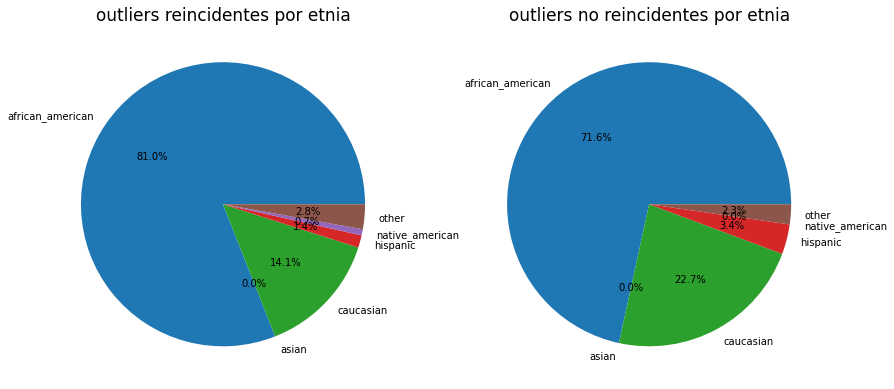

In [94]:
# Piechart by race
labels = ['african_american', 'asian', 'caucasian', 'hispanic', 'native_american', 'other']

recid_race_count = [len(reincident_people[reincident_people['race_African-American'] == 1]), 
                    len(reincident_people[reincident_people['race_Asian'] == 1]), 
                    len(reincident_people[reincident_people['race_Caucasian'] == 1]),
                    len(reincident_people[reincident_people['race_Hispanic'] == 1]), 
                    len(reincident_people[reincident_people['race_Native American'] == 1]), 
                    len(reincident_people[reincident_people['race_Other'] == 1])
                  ]

not_recid_race_count = [len(not_recid_people[not_recid_people['race_African-American'] == 1]), 
                        len(not_recid_people[not_recid_people['race_Asian'] == 1]), 
                        len(not_recid_people[not_recid_people['race_Caucasian'] == 1]),
                        len(not_recid_people[not_recid_people['race_Hispanic'] == 1]), 
                        len(not_recid_people[not_recid_people['race_Native American'] == 1]), 
                        len(not_recid_people[not_recid_people['race_Other'] == 1])
                        ]

plt.figure(figsize=(14, 10))
plt.subplot(1,2,1)
plt.title('outliers reincidentes por etnia', size=17)
plt.pie(recid_race_count, labels=labels, autopct='%1.1f%%')
plt.subplot(1,2,2)
plt.title('outliers no reincidentes por etnia', size=17)
plt.pie(not_recid_race_count, labels=labels, autopct='%1.1f%%')
plt.show()



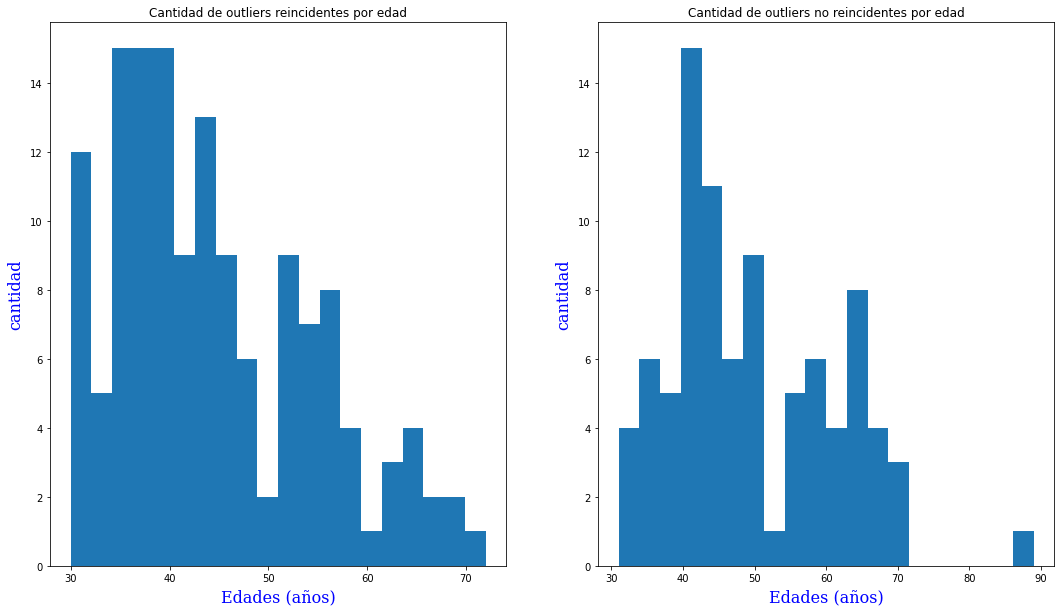

In [75]:
import datetime

ages_r = reincident_people['dob'] * 36604 - 18342 # float to posix
ages_r = ages_r.map(lambda x:int((datetime.datetime.now() - (datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=int(86400*x))) ).days//365.25)) # convert to years
ages_nr = not_recid_people['dob'] * 36604 - 18342 # float to posix
ages_nr = ages_nr.map(lambda x:int((datetime.datetime.now() - (datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=int(86400*x))) ).days//365.25))

plt.figure(figsize=(18, 10))


plt.subplot(1,2,1)
plt.title('Cantidad de outliers reincidentes por edad')
plt.hist(ages_r, bins=20)
plt.xlabel("Edades (años)",
           family='serif',
           color='b',
           weight='normal',
           size = 16,
           labelpad = 6)
plt.ylabel("cantidad",
           family='serif',
           color='b',
           weight='normal',
           size = 16,
           labelpad = 6)
plt.subplot(1,2,2)
plt.title('Cantidad de outliers no reincidentes por edad')
plt.hist(ages_nr, bins=20)
plt.xlabel("Edades (años)",
           family='serif',
           color='b',
           weight='normal',
           size = 16,
           labelpad = 6)
plt.ylabel("cantidad",
           family='serif',
           color='b',
           weight='normal',
           size = 16,
           labelpad = 6)
plt.show()

In [ ]:
reincident_people['max_degree'].value_counts()

0.90    122
1.00     79
0.85     28
0.60      1
Name: max_degree, dtype: int64

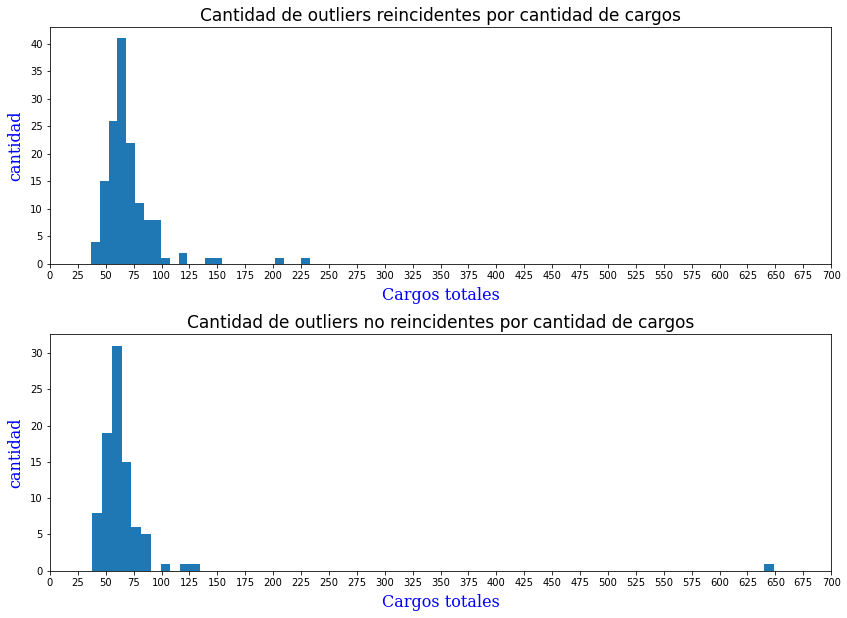

In [92]:
plt.figure(figsize=(14, 10))
plt.subplot(2,1,1)
plt.hist(reincident_people['charges_total'], bins=25)
plt.title('Cantidad de outliers reincidentes por cantidad de cargos', size=17)
plt.xlabel("Cargos totales",
           family='serif',
           color='b',
           weight='normal',
           size = 16,
           labelpad = 6)
plt.ylabel("cantidad",
           family='serif',
           color='b',
           weight='normal',
           size = 16,
           labelpad = 6)
plt.xticks(np.arange(0, 725, 25))
plt.subplot(2,1,2)
plt.hist(not_recid_people['charges_total'], bins=70)
plt.title('Cantidad de outliers no reincidentes por cantidad de cargos', size=17)
plt.xlabel("Cargos totales",
           family='serif',
           color='b',
           weight='normal',
           size = 16,
           labelpad = 6)
plt.ylabel("cantidad",
           family='serif',
           color='b',
           weight='normal',
           size = 16,
           labelpad = 6)
plt.xticks(np.arange(0, 725, 25))
plt.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
# Guardamos la informacion
main_people.to_csv('../data/cleaned/cluster_people.csv', index=False)

#### Conclusión
No se pudieron evidenciar grupos claros que compartan reincidencia, por lo que a priori no existen grupos grandes de personas que definan claramente la reincidencia. Sin embargo, existe un grupo menor "marginado" que posee una muy alta reincidencia. El cual esta compuesto mayoritariamente por hombres (90.8%), afroamericanos (81.0%), normalmente entre los 35 y 47 años aproximadamente (27 y 39 años a la fecha de los datos) y con una gran cantidad de cargos, todos teniendo sobre los 30 cargos y practicamente todos son responsables de felonias.

Volviendo entonces a la pregunta: **¿Existirán grupos de personas que compartan la misma tasa de reincidencia? Si existen, ¿Qué atributos componen a dichos grupos?** Utilizando tecnicas de clustering solo se encontro 1 grupo de personas que componen una tasa de reincidencia notablemente distinta al resto del dataset. Cabe notar que si bien el grupo es de un tamaño menor a 300 personas de aproximadamente 11000, aún así logra encajar con una imagen estereotipica del criminal popularizado por la cultura estado unidense.